In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import scienceplots
import pandas as pd
from itertools import combinations
import pprint
from shapely.geometry import Polygon
plt.style.use(['science', 'grid'])

from utils import (
    load_dataset,
    get_images,
    transform_points,
    get_densities,
    predict,
    calculate_errors,
    get_result_dict,
    SCALING_FACTOR,
    plot_setup, 
    plot_setup_noised,
    plot_predictions,
    add_outlier
)

We will use two points that are similar distance to ref pt, etc. and use four points to determine a homography to have full control. Let us use points **w6, w8, w9, w22** in **DJI_0026** and validation points **b8** and **b21**. Validation point b8 has pixel density of **182.68** and an error of **xx px** and validation point b21 **346.01** and an error of **xx px**, respectively.

Now let us add random noise 100 times to the reference points and recalculate the errors. The hypothesis is, that b21 can deal better with the simulated measurement errors, as it has more pixel density. 

Results:
- std: 0, b8: 2.92, b21: 3.24
- std: 5, b8: 10.69, b21: 9.32
-  std: 10, b8: 20.52, b21: 18.42
- std: 20, b8: 42.73, b21: 35.04
- std: 30, b8: 64.38, b21: 51.56
- std: 50, b8: 124.21, b21: 94.40

Let's check it with another image and two other points to validate it once more.

## Conduct Experiment

In [2]:
def filter_points(points, keys):
    filtered = {key: points[key] for key in keys}
    return filtered

def calc_error(pt, gt, h):
    homog_pt = np.array((pt[0], pt[1], 1))
    predicted_pt = predict(homog_pt, h)
    gt_pt = np.array(gt)
    error = np.linalg.norm(predicted_pt[:2] - gt_pt)
    return error

def add_noise(points, m=0, std=1):
    zeros = np.zeros((points.shape[0], 1))
    noise = np.random.normal(m, std, points[:,:-1].shape)
    noise = np.hstack((noise, zeros))
    return points + noise

def conduct_experiment(pv_img, tv_img, used_ref_points, n_std, val_pt1, val_pt2):
    reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
    img_pv, img_tv = get_images(pv_img, tv_img)
    # used_ref_points = ['w6', 'w8', 'w9', 'w22']
    
    reference_pts_pv = filter_points(reference_pts_pv, used_ref_points)
    reference_pts_tv = filter_points(reference_pts_tv, used_ref_points)
        
    # Transform Points to Homogeneous Numpy arrays
    reference_pts_pv_arr, reference_pts_tv_arr, validation_pts_pv_arr, validation_pts_tv_arr = transform_points(
        reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv)

    reference_pts_pv_arr_noised = add_noise(reference_pts_pv_arr, 0, n_std)
    reference_pts_tv_arr_noised = add_noise(reference_pts_tv_arr, 0, n_std)
    
    # Calculate Homography
    h, _ = cv2.findHomography(
        reference_pts_pv_arr_noised,
        reference_pts_tv_arr_noised,
        # method = cv2.RANSAC,
        method = 0,
    )
    h_inv = np.linalg.inv(h)
    error1 = calc_error(validation_pts_pv[val_pt1], validation_pts_tv[val_pt1], h)
    error2 = calc_error(validation_pts_pv[val_pt2], validation_pts_tv[val_pt2], h)
    return error1, error2

In [11]:
used_ref_pts = ['w6', 'w8', 'w9', 'w22']
used_val_pts = ['b8', 'b21']
used_ref_pts2 = ['w21', 'w23', 'w28', 'w26']
used_val_pts2 = ['b28', 'b24']

def get_results(pv_img, tv_img, used_ref_pts, used_val_pts):
    results = {}
    for std in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]:
        results[std] = {}
        results[std][used_val_pts[0]] = []
        results[std][used_val_pts[1]] = []
        errors = []
        for i in range(100):
            _errors = conduct_experiment(pv_img, tv_img, used_ref_pts, std, used_val_pts[0], used_val_pts[1])
            results[std][used_val_pts[0]].append(_errors[0])
            results[std][used_val_pts[1]].append(_errors[1])
    return results
results1 = get_results('DJI_0026', 'DJI_0017', used_ref_pts, used_val_pts)
results2 = get_results('DJI_0029', 'DJI_0017', used_ref_pts2, used_val_pts2)

## Print Results 

In [4]:
pv_img = 'DJI_0026'
tv_img = 'DJI_0017'

_errors = conduct_experiment(pv_img, tv_img, used_ref_pts, 0, used_val_pts[0], used_val_pts[1])
print(f'std: 0, {used_val_pts[0]}: {_errors[0]:.2f}, {used_val_pts[1]}: {_errors[1]:.2f}')
for std, result_d in results1.items():
    b8_error = np.mean(result_d[used_val_pts[0]])
    b21_error = np.mean(result_d[used_val_pts[1]])
    print(f'std: {std}, {used_val_pts[0]}: {b8_error:.2f}, {used_val_pts[1]}: {b21_error:.2f}')

std: 0, b8: 2.92, b21: 3.24
std: 5, b8: 12.15, b21: 7.72
std: 10, b8: 20.53, b21: 20.76
std: 15, b8: 37.26, b21: 23.39
std: 20, b8: 36.14, b21: 26.76
std: 25, b8: 44.14, b21: 40.20
std: 30, b8: 50.14, b21: 60.59
std: 35, b8: 70.25, b21: 34.18
std: 40, b8: 107.67, b21: 80.35
std: 45, b8: 114.66, b21: 98.73
std: 50, b8: 71.93, b21: 65.77
std: 55, b8: 121.48, b21: 151.21
std: 60, b8: 121.35, b21: 94.30
std: 65, b8: 158.03, b21: 148.29
std: 70, b8: 187.25, b21: 155.97


In [5]:
pv_img = 'DJI_0029'
tv_img = 'DJI_0017'
_errors = conduct_experiment('DJI_0029', tv_img, used_ref_pts2, 0, used_val_pts2[0], used_val_pts2[1])
print(f'std: 0, {used_val_pts2[0]}: {_errors[0]:.2f}, {used_val_pts2[1]}: {_errors[1]:.2f}')
for std, result_d in results2.items():
    b8_error = np.mean(result_d[used_val_pts2[0]])
    b21_error = np.mean(result_d[used_val_pts2[1]])
    print(f'std: {std}, {used_val_pts2[0]}: {b8_error:.2f}, {used_val_pts2[1]}: {b21_error:.2f}')

std: 0, b28: 0.85, b24: 3.86
std: 5, b28: 5.91, b24: 11.40
std: 10, b28: 12.95, b24: 22.24
std: 15, b28: 21.34, b24: 37.39
std: 20, b28: 29.83, b24: 41.11
std: 25, b28: 32.26, b24: 53.53
std: 30, b28: 43.53, b24: 70.91
std: 35, b28: 41.69, b24: 109.21
std: 40, b28: 47.75, b24: 92.26
std: 45, b28: 64.40, b24: 82.55
std: 50, b28: 61.13, b24: 134.99
std: 55, b28: 91.00, b24: 112.26
std: 60, b28: 58.89, b24: 133.04
std: 65, b28: 68.93, b24: 133.40
std: 70, b28: 131.96, b24: 152.05


## Plot Setup

In [6]:
def plot_reference_point(name, x, y, ax, fc='white', ec='black', x_offset=-50, y_offset=0, fontcolor='black'):
    ax.plot(x, y, marker='X', markersize=8, color='whitesmoke')
    ax.annotate(name, 
        xy=(x, y),
        color=fontcolor,
        bbox=dict(facecolor=fc, edgecolor=ec, boxstyle="round", alpha=0.8)
    )
    
def plot_reference_points(reference_pts_pv, ax):
    for name, pt in reference_pts_pv.items(): 
        plot_reference_point(name, pt[0], pt[1], ax)

def plot_validation_points(validation_pts_pv, ax):
    for name, pt in validation_pts_pv.items(): 
        plot_reference_point(name, pt[0], pt[1], ax, fc='blue', ec='black', fontcolor='white')

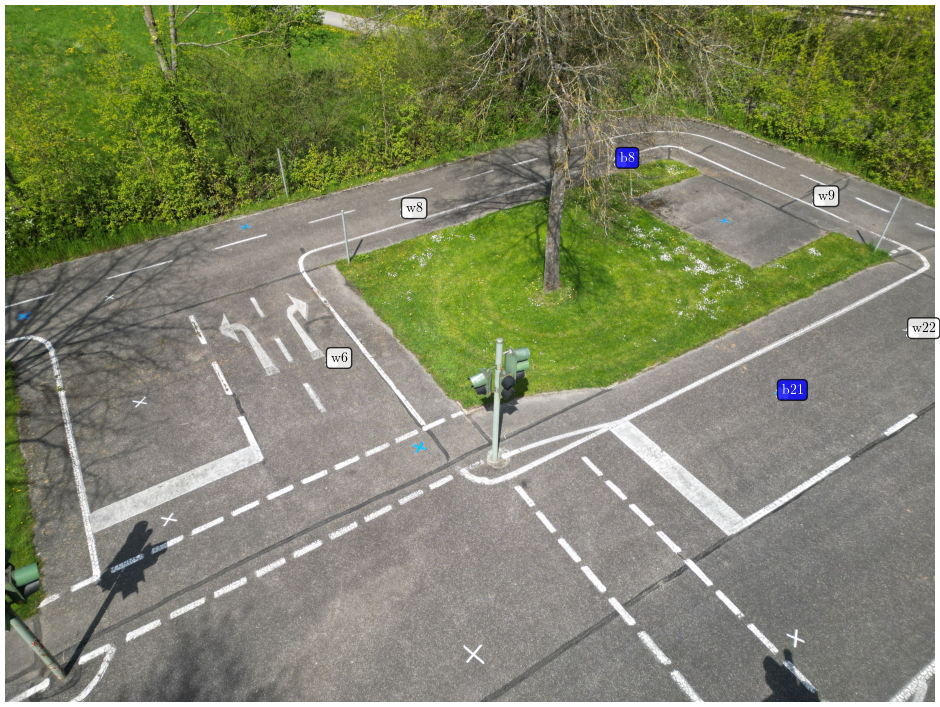

In [7]:
pv_img = 'DJI_0026'
tv_img = 'DJI_0017'
used_val_points = ['b8', 'b21']
img_pv, img_tv = get_images(pv_img, tv_img)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
reference_pts_pv = filter_points(reference_pts_pv, used_ref_pts)
validation_pts_pv = filter_points(validation_pts_pv, used_val_points)

ax.imshow(img_pv)
ax.axis('off')
plot_reference_points(reference_pts_pv, ax)
plot_validation_points(validation_pts_pv, ax)

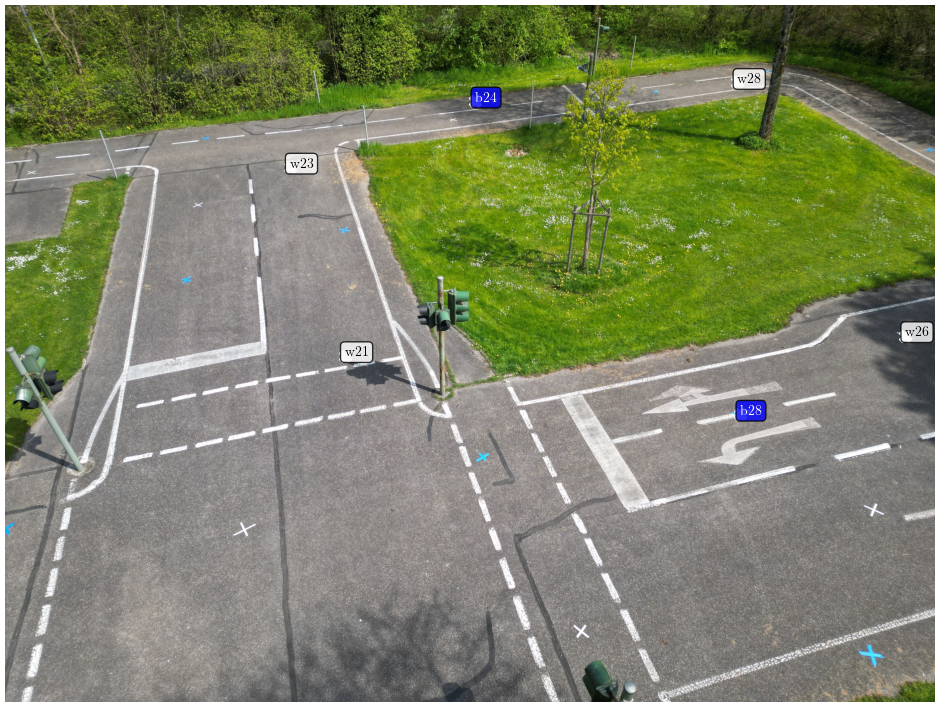

In [8]:
pv_img = 'DJI_0029'
tv_img = 'DJI_0017'
used_ref_points = ['w21', 'w23', 'w28', 'w26']
used_val_points = ['b28', 'b24']
img_pv, img_tv = get_images(pv_img, tv_img)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
reference_pts_pv, reference_pts_tv, validation_pts_pv, validation_pts_tv = load_dataset(pv_img, tv_img)
reference_pts_pv = filter_points(reference_pts_pv, used_ref_points)
validation_pts_pv = filter_points(validation_pts_pv, used_val_points)

ax.imshow(img_pv)
ax.axis('off')
plot_reference_points(reference_pts_pv, ax)
plot_validation_points(validation_pts_pv, ax)

## Plot Results

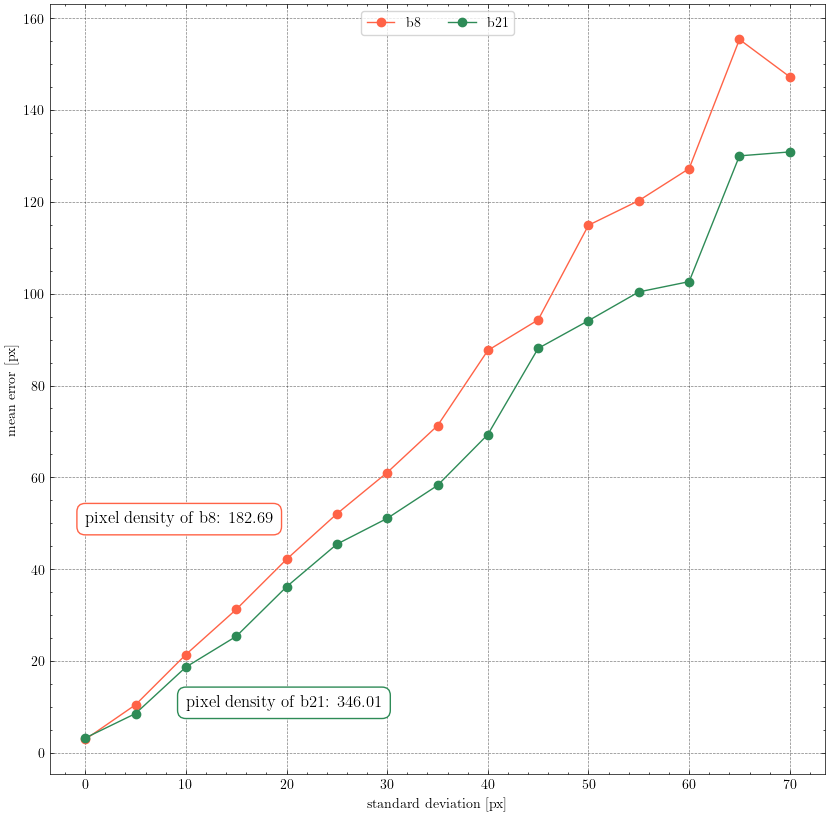

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

errors_bad = []
errors_good = []
stds = [0]

error = conduct_experiment('DJI_0026', tv_img, used_ref_pts, 0, used_val_pts[0], used_val_pts[1])
errors_bad.append(error[0])
errors_good.append(error[1])

for std, result_dict in results1.items():
    stds.append(std)
    errors_bad.append(np.mean(result_dict['b8']))
    errors_good.append(np.mean(result_dict['b21']))
    
ax.plot(stds, errors_bad, color='tomato', marker='o', label='b8')
ax.plot(stds, errors_good, color='seagreen', marker='o', label='b21')
ax.set_xlabel('standard deviation [px]')
ax.set_ylabel('mean error [px]')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=False, framealpha=0.8)

ax.annotate(
    'pixel density of b8: 182.69', 
    xy=(0, 50),
    color='black',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='tomato', boxstyle="round", pad=0.5)
)
ax.annotate(
    'pixel density of b21: 346.01', 
    xy=(10, 10),
    color='black',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='seagreen', boxstyle="round", pad=0.5)
)

plt.savefig('pixel_density_0026.png', dpi=300)
plt.show()

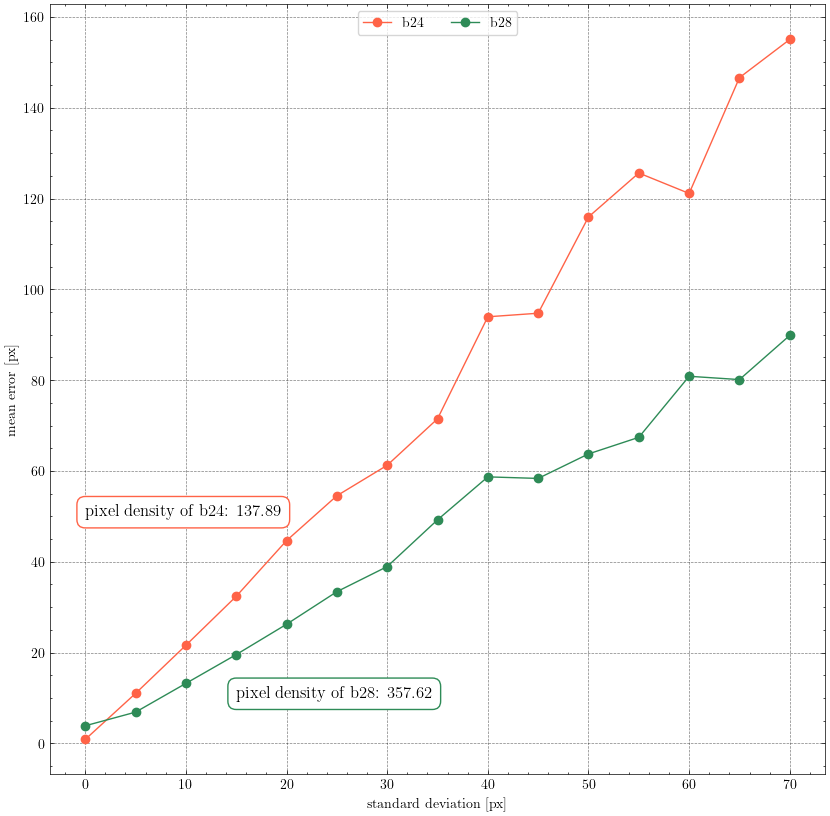

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

errors_bad = []
errors_good = []
stds = [0]

error = conduct_experiment('DJI_0029', tv_img, used_ref_pts2, 0, used_val_pts2[0], used_val_pts2[1])
errors_bad.append(error[0])
errors_good.append(error[1])

for std, result_dict in results2.items():
    stds.append(std)
    errors_bad.append(np.mean(result_dict['b24']))
    errors_good.append(np.mean(result_dict['b28']))
    
ax.plot(stds, errors_bad, color='tomato', marker='o', label='b24')
ax.plot(stds, errors_good, color='seagreen', marker='o', label='b28')

ax.set_xlabel('standard deviation [px]')
ax.set_ylabel('mean error [px]')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=3, fancybox=True, shadow=False, framealpha=0.8)

ax.annotate(
    'pixel density of b24: 137.89', 
    xy=(0, 50),
    color='black',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='tomato', boxstyle="round", pad=0.5)
)
ax.annotate(
    'pixel density of b28: 357.62', 
    xy=(15, 10),
    color='black',
    fontsize=12,
    bbox=dict(facecolor='white', edgecolor='seagreen', boxstyle="round", pad=0.5)
)

plt.savefig('pixel_density_0029.png', dpi=300)
plt.show()